findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


The prediction result of LS classification with gaussian basis is:
              precision    recall  f1-score   support

     class 1       0.78      0.95      0.86       100
     class 2       0.83      0.47      0.60        51

    accuracy                           0.79       151
   macro avg       0.80      0.71      0.73       151
weighted avg       0.80      0.79      0.77       151

AUC:  0.76
*****Result for Training Data*****
              precision    recall  f1-score   support

     class 1       0.81      0.96      0.88       729
     class 2       0.69      0.27      0.39       220

    accuracy                           0.80       949
   macro avg       0.75      0.62      0.63       949
weighted avg       0.79      0.80      0.77       949

AUC:  0.77


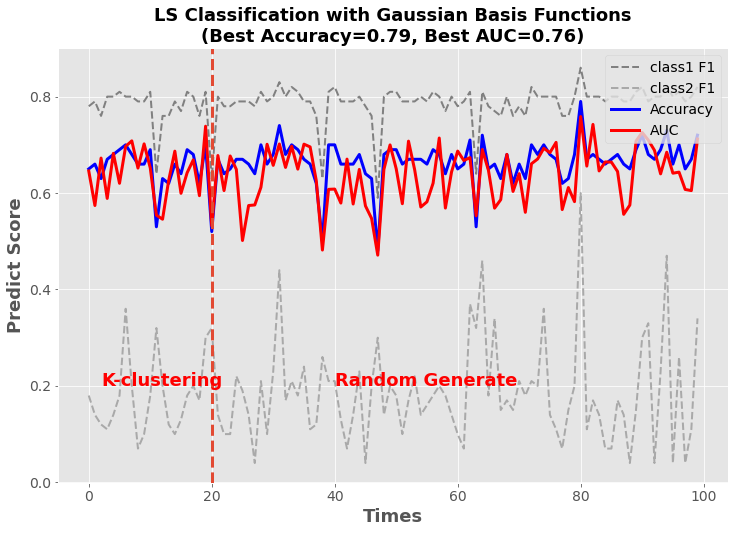

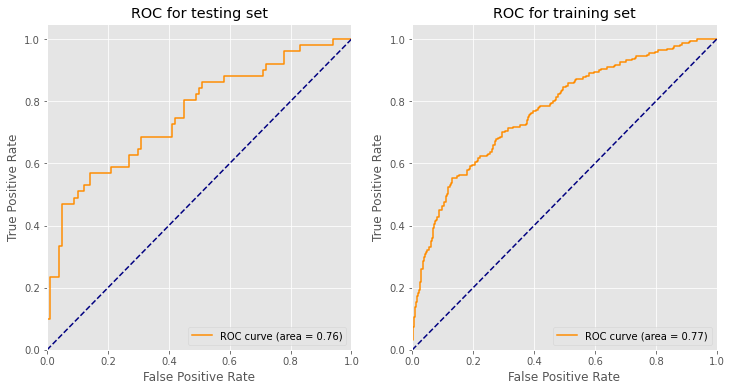

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import roc_auc_score
class LeastGaussian():
    def __init__(self):
        self.recordDict = {"class1 F1": [], "class2 F1": [], "Accuracy": [], "AUC": []}
        self.readData()
        self.dataSqrt(1/4)
        self.outsideAdj()
        self.kClusteringMean(20)
        self.normalRandomMean(80, 119020084)
        self.probaLst = []

    def readData(self):
        train_org = pd.read_csv("../data/imp_train.csv")
        self.train_x = train_org.drop(['class'], axis = 1)
        self.origin_y = train_org["class"]
        self.train_y = self.classOneHot(train_org["class"])
        test_org = pd.read_csv("../data/imp_test.csv") 
        self.test_x = test_org.drop(['class'], axis = 1)
        self.test_y = test_org["class"]

    def classOneHot(self, label_arr):
        """
        Transform label array into matrix. The size is n*k, k is the number of classes
        This is one-hot transformation
        """
        n_class = np.unique(label_arr).size
        y_matrix = np.zeros((label_arr.shape[0],n_class))
        y_matrix[label_arr==0,0] = 1
        y_matrix[label_arr==1,1] = 1
        return y_matrix.T

    def dataSqrt(self, power):
        """
        First transform all the data into positive
        Then take square root
        Lastly, transform the negative data into negative.
        """
        train_x_abs = np.power(np.abs(self.train_x), power)
        train_x_abs[self.train_x<0] = -train_x_abs[self.train_x<0]
        self.train_x = train_x_abs
        test_x_abs = np.power(np.abs(self.test_x), power)
        test_x_abs[self.test_x<0] = -test_x_abs[self.test_x<0]
        self.test_x = test_x_abs


    def outsideAdj(self):
        mu = self.train_x.mean()
        sigma = np.sqrt(self.train_x.var())
        upper_bound = mu + 1 * sigma
        lower_bound = mu - 1 * sigma
        for attr in lower_bound.index:
            self.train_x[attr][self.train_x[attr] > upper_bound[attr]] = upper_bound[attr]
            self.test_x[attr][self.test_x[attr] > upper_bound[attr]] = upper_bound[attr]
            self.train_x[attr][self.train_x[attr] < lower_bound[attr]] = lower_bound[attr]
            self.test_x[attr][self.test_x[attr] < lower_bound[attr]] = lower_bound[attr]
        self.train_x = (self.train_x - self.train_x.min()) / (self.train_x.max() - self.train_x.min())*10
        self.test_x = (self.test_x - self.test_x.min()) / (self.test_x.max() - self.test_x.min())*10

    def kClusteringMean(self, n):
        """
        Use k-clustering method to find 20 mean values
        """
        train_adj = self.train_x.copy()
        train_adj["cluster"] = KMeans(n_clusters=n, max_iter=10000, random_state=119020).fit_predict(self.train_x)
        train_adj_mean = train_adj.groupby("cluster").mean()
        self.k_cluster_mean = train_adj_mean

    def normalRandomMean(self, n, seed):
        mean_var_lst = list(zip(self.train_x.mean(), np.sqrt(self.train_x.var())))
        zeros = np.zeros([n, len(mean_var_lst)])
        for attr in range(len(mean_var_lst)):
            np.random.seed(seed)
            zeros[:,attr] = np.random.normal(mean_var_lst[attr][0], mean_var_lst[attr][1],n)
        zeros = pd.DataFrame(zeros, columns = self.k_cluster_mean.columns)
        self.mean_generate = pd.concat([pd.DataFrame(zeros), self.k_cluster_mean])
        

    def gaussianTransform(self, row):
        gaussian_x_train = np.exp(- (self.train_x - self.mean_generate.iloc[row,])**2 / 2 * self.train_x.var())
        guassian_x_test = np.exp(- (self.test_x - self.mean_generate.iloc[row,])**2 / 2 * self.test_x.var())
        gaussian_x_train["constant"] = 1
        guassian_x_test["constant"] = 1
        self.gaussian_x_train = np.array(gaussian_x_train).T
        self.gaussian_x_test = np.array(guassian_x_test).T
    
    def gaussianTrain(self, row):
        self.gaussianTransform(row)
        T_XT = np.dot(self.train_y, self.gaussian_x_train.T)
        X_XT_inv = np.linalg.pinv(np.dot(self.gaussian_x_train, self.gaussian_x_train.T))
        self.parameters = np.dot(T_XT, X_XT_inv)
        self.gaussian_predict()

    def gaussian_predict(self, train_test=False):
        df = pd.DataFrame(np.dot(self.parameters, self.gaussian_x_test)).T
        self.mydf = df
        df["predict"] = 0
        df.loc[df[1]>df[0], "predict"] = 1
        target_names = ['class 1', 'class 2']
        self.auc_score = roc_auc_score(np.array(self.test_y), df[1])
        self.probaLst.append(df[1])
        result = classification_report(np.array(self.test_y), df['predict'], target_names=target_names)
        self.result = result
        self.recordDict["class1 F1"].append(float(self.result.split("\n")[2].split()[4]))
        self.recordDict["class2 F1"].append(float(self.result.split("\n")[3].split()[4]))
        self.recordDict["Accuracy"].append(float(self.result.split("\n")[5].split()[1]))
        self.recordDict["AUC"].append(self.auc_score)
    
    def resultVisualize(self):
        plt.figure(figsize=(12,8))
        plt.style.use("ggplot")   
        plt.plot(self.recordDict["class1 F1"], linestyle='--', color="grey",lw=2)
        plt.plot(self.recordDict["class2 F1"], linestyle='--', color="darkgrey",lw=2)
        plt.plot(self.recordDict["Accuracy"], linestyle='-', color="blue", lw=3)
        plt.plot(self.recordDict["AUC"], linestyle='-', color="red", lw=3)
        plt.axvline(20, ls="--", lw=3)
        plt.legend(self.recordDict.keys(), fontsize=14, loc=1)
        plt.text(2, 0.2, "K-clustering", color = "red", font = {'family': 'normal', 'weight': 'bold', 'size': 18})
        plt.text(40, 0.2, "Random Generate", color = "red", font = {'family': 'normal', 'weight': 'bold', 'size': 18})
        plt.xlabel("Times", font = {'family': 'normal', 'weight': 'bold', 'size': 18})
        plt.ylabel("Predict Score", font = {'family': 'normal', 'weight': 'bold', 'size': 18})
        plt.xticks(font = {'family': 'normal', 'weight': 'normal', 'size': 14})
        plt.yticks(font = {'family': 'normal', 'weight': 'normal', 'size': 14})
        plt.title("LS Classification with Gaussian Basis Functions\n(Best Accuracy={}, Best AUC={})".format(np.array(self.recordDict["Accuracy"]).max(),\
            np.round(np.array(self.recordDict["AUC"]).max(), 2)),\
             font = {'family': 'normal', 'weight': 'bold', 'size': 18})
    
    def resultReport(self):
        acc_array = np.array(self.recordDict["Accuracy"])
        best_row = np.where(acc_array == acc_array.max())[0][0]
        self.gaussianTrain(best_row)
        print(self.result)
        print("AUC: ", np.round(self.auc_score, 2))

    def draw_roc(self):
        score = self.probaLst[-1]
        score = (score - score.min()) / (score.max() - score.min())
        auc = roc_auc_score(self.test_y, score)
        fpr, tpr, _ = roc_curve(self.test_y, score)
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.plot(fpr, tpr, color='darkorange',
                label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC for testing set')
        plt.legend(loc="lower right")

        self.gaussian_x_test = self.gaussian_x_train
        self.test_y = self.origin_y
        self.gaussian_predict()
        print("*****Result for Training Data*****")
        print(self.result)
        print("AUC: ", np.round(self.auc_score, 2))
        score = self.probaLst[-1]
        score = (score - score.min()) / (score.max() - score.min())
        auc = roc_auc_score(self.origin_y, score)
        fpr, tpr, _ = roc_curve(self.origin_y, score)
        plt.subplot(122)
        plt.plot(fpr, tpr, color='darkorange',
                label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC for training set')
        plt.legend(loc="lower right")
        plt.show()

if __name__ == "__main__":
    p = LeastGaussian()
    for i in range(100):
        p.gaussianTrain(i)
    p.resultVisualize()
    print("The prediction result of LS classification with gaussian basis is:")
    p.resultReport()
    p.draw_roc()